# 1. Import Libraries

In [ ]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# interactive visualizarion libaries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# scikit learn clustering library
from sklearn.cluster import KMeans
# import the silhouette metric
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib import style

#always :)
style.use("dark_background") 

# 2. Read Data 

In [2]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3.  
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset.  
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features were **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. Therefore, the amount will be from now on expressed in US dollars.  

**Other transformations:**  
- All Unknown for **Age** will be kept. It appears that only Enterprise gender doesn’t have its age, so the missingness is systematic. The `U` will be replaced with number `7`.  
- All Unknown for **Gender** will be erased. It appears that the age for these people is in `1`, `2`, and `3` intervals, which each has an average distribution of `F = 55%`, `M = 44%`, `U = 1%`.

### Preprosessing

In [4]:
# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender column to numeric values
df['gender'] = df['gender'].replace({"'M'": 0, "'F'": 1, "'E'": 2}).infer_objects(copy=False)

# encode the 'category' column to numeric values
# save the unique categories for later use
categories = df['category'].unique()
# create a mapping dictionary for the categories
category_mapping = {category: idx for idx, category in enumerate(categories)}
# map the categories to their corresponding numeric values
df['category'] = df['category'].map(category_mapping)
# convert the 'category' column to categorical type and then to numeric codes
df.loc[:, 'category'] = df['category'].astype('category').cat.codes

C:\Users\ppapa\AppData\Local\Temp\ipykernel_19412\812698645.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({"'M'": 0, "'F'": 1, "'E'": 2}).infer_objects(copy=False)


In [5]:
df.head()

,age,gender,category,amount,fraud
0,4,0,0,4.55,0
1,2,0,0,39.68,0
2,4,1,0,26.89,0
3,3,0,0,17.25,0
4,5,0,0,35.72,0


### Plotting

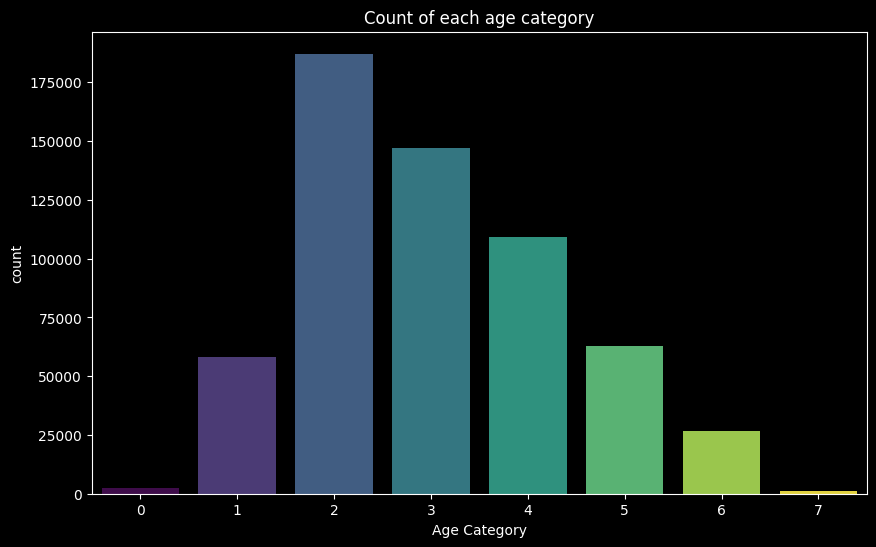

In [6]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='viridis', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

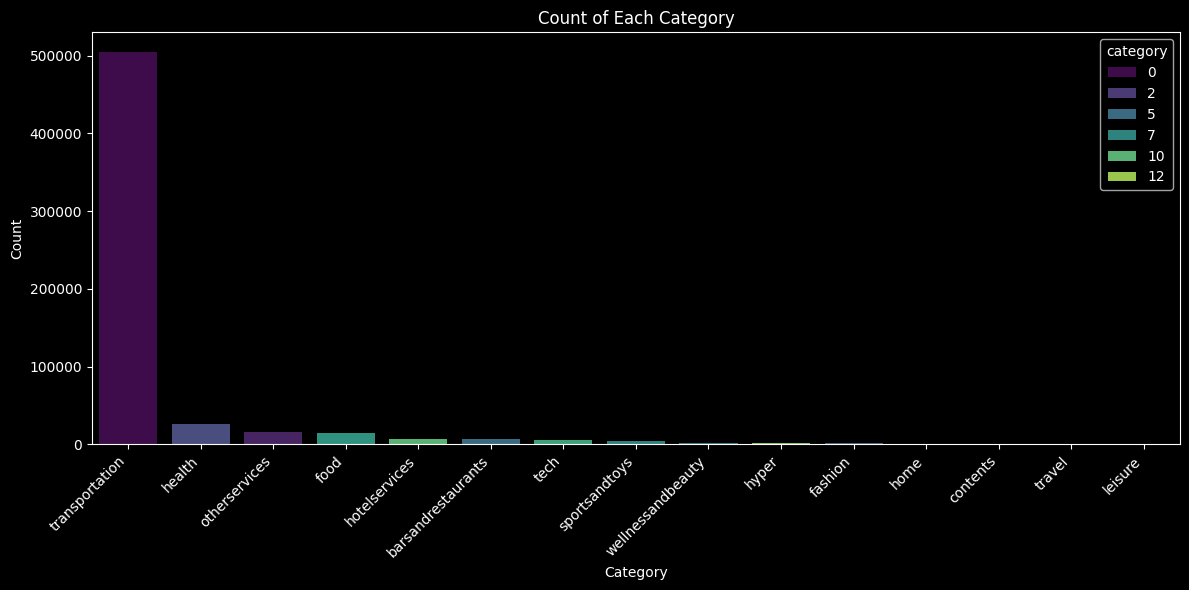

In [7]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category', 
    hue='category', 
    order=df['category'].value_counts().index, 
    palette='viridis', 
    dodge=False)
plt.xticks(ticks=range(len(category_mapping)), labels=[key.strip("'") for key in category_mapping.keys()], rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

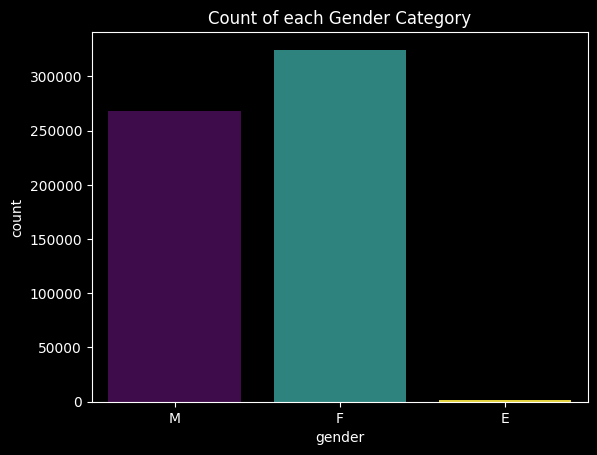

In [8]:
#plot count of each gender
sns.countplot(data=df, x='gender', hue='gender', palette='viridis', legend=False);
plt.title('Count of each Gender Category')
plt.xticks(ticks=[0, 1, 2], labels = ['M', 'F', 'E'])
plt.show()

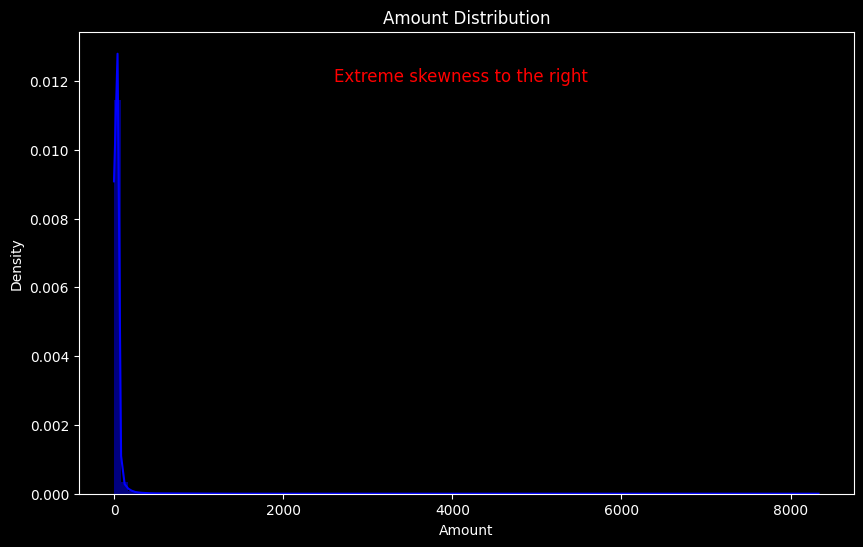

In [9]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

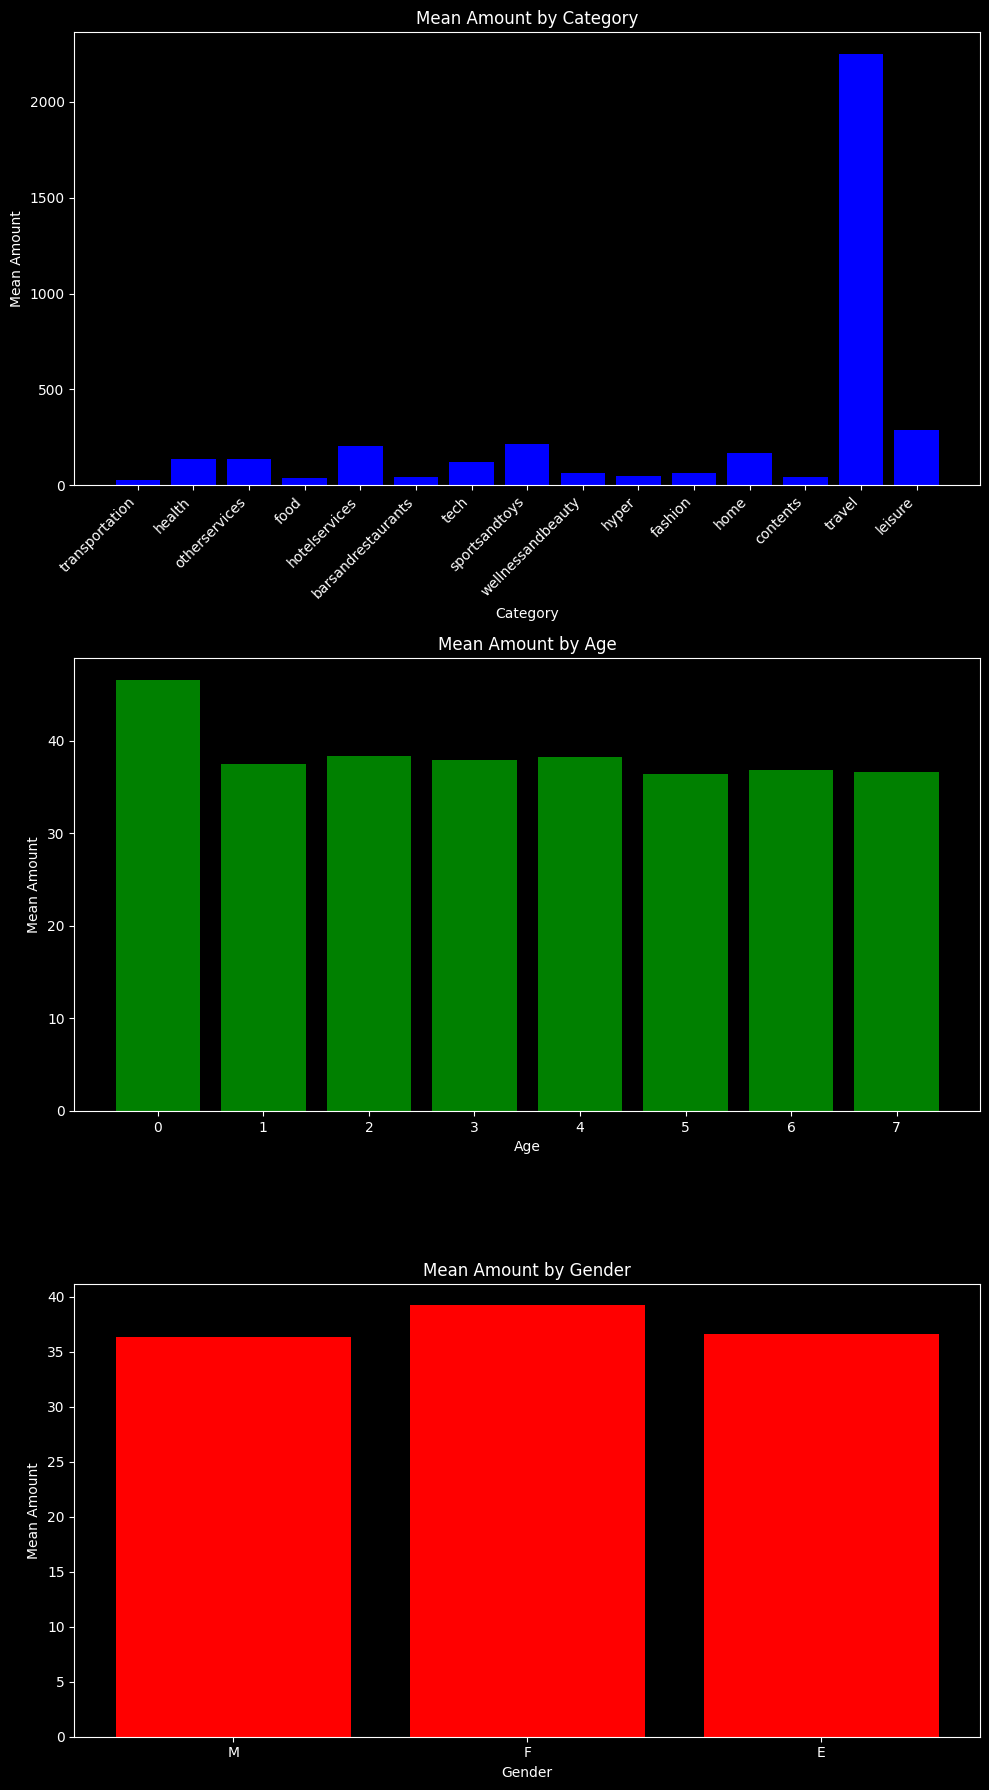

In [10]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category')['amount'].describe().index, df.groupby('category')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(ticks=range(len(category_mapping)), labels=[key.strip("'") for key in category_mapping.keys()], rotation=45, ha='right')
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender')['amount'].describe().index, df.groupby('gender')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.xticks(ticks=[0, 1, 2], labels = ['M', 'F', 'E'])
plt.tight_layout()
plt.show()


#### Fraud Plots

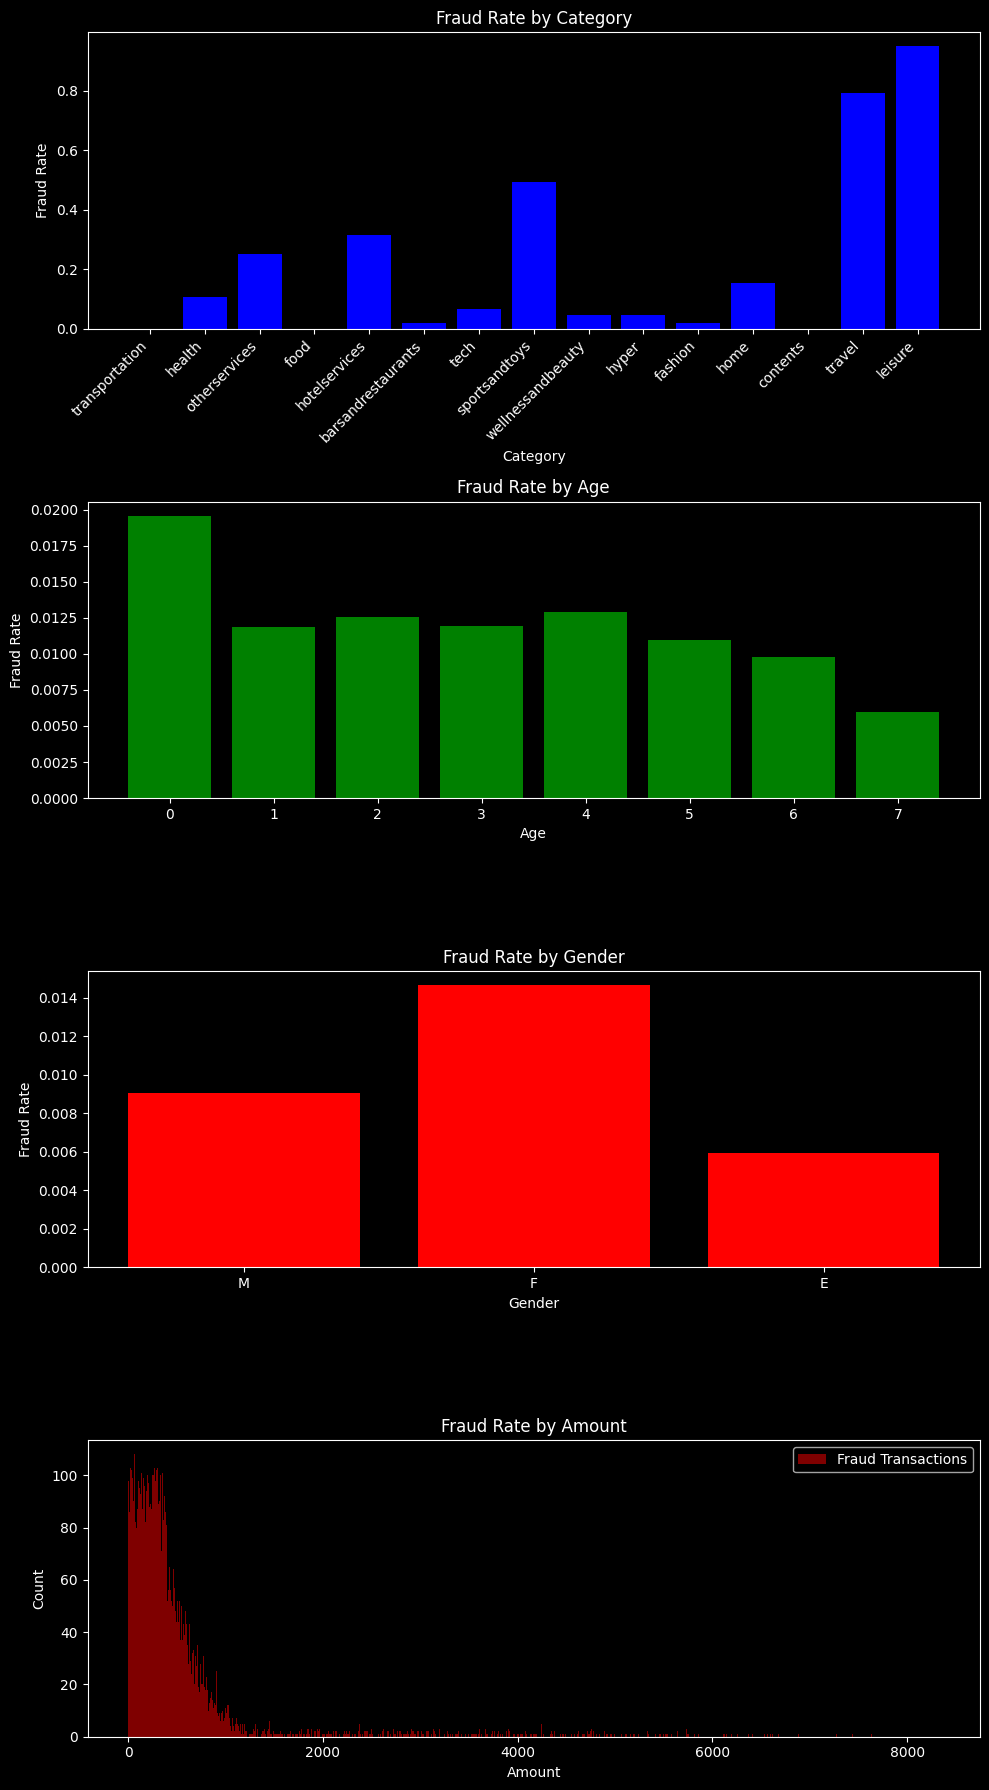

In [11]:
# plot the frauds distribution in corelation with the amount / gender / age / category
plt.figure(figsize=(10, 18))
plt.subplot(4, 1, 1)
plt.bar(df.groupby('category')['fraud'].describe().index, df.groupby('category')['fraud'].describe()['mean'], color='blue')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.xticks(ticks=range(len(category_mapping)), labels=[key.strip("'") for key in category_mapping.keys()], rotation=45, ha='right')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 2)
plt.bar(df.groupby('age')['fraud'].describe().index, df.groupby('age')['fraud'].describe()['mean'], color='green')
plt.title('Fraud Rate by Age')
plt.xlabel('Age')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 3)
plt.bar(df.groupby('gender')['fraud'].describe().index, df.groupby('gender')['fraud'].describe()['mean'], color='red')
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.xticks(ticks=[0, 1, 2], labels = ['M', 'F', 'E'])
plt.subplot(4, 1, 4)

# plot the fraud rate by amount, using bins of 1000
plt.hist(df[df['fraud'] == 1]['amount'], bins=1000, color='red', alpha=0.5, label='Fraud Transactions')
plt.title('Fraud Rate by Amount')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Clustering

In [12]:
# select X as the features for clustering (everything except the fraud column)
X = df.drop(columns=['fraud']).copy()

In [13]:
# empty list to contain the score of each cluster.
clustering_score = []

# Get the inertia score for 10 models, from 1 cluster to 10.
for clusters_number in range(1, 11):
    # initiate and customize algo
    model = KMeans(n_clusters=clusters_number, random_state=0)
    # fit algo to the data
    model.fit(X)
    # inertia_ = Sum of squared distances of samples to their closest cluster center.
    # this is the Within Clusters Sum of Squares metric, WCSS
    clustering_score.append(model.inertia_)

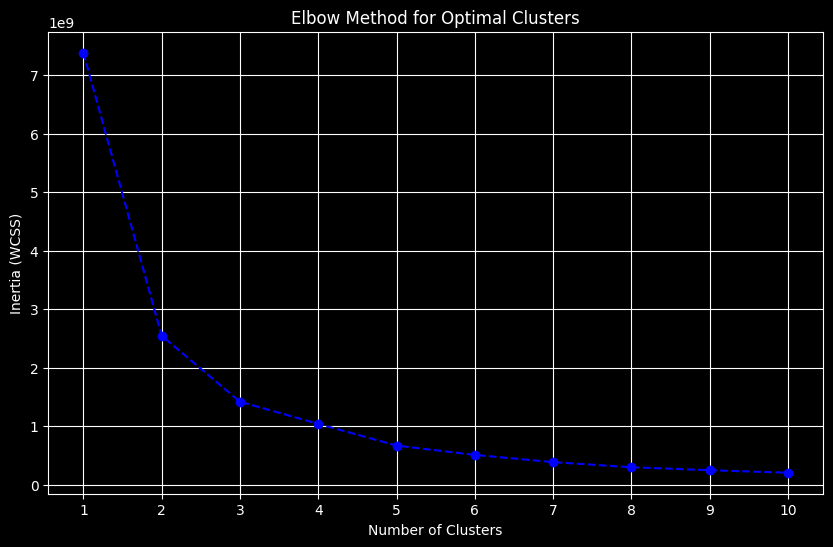

In [14]:
# plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), clustering_score, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(range(1, 11))
plt.grid()


In [15]:
# This takes too long to run, so I commented it out.
# Dont try this at home!

# #create empty list to store score
# silhouette_scores_list = []

# # loop from 2 to 4 clusters:
# for clusters_number in range(2, 5):  # Silhouette starts from 2 clusters.
#     # initiate and customize algo
#     model = KMeans(n_clusters=clusters_number, random_state=0)
#     # fit algo to the data
#     clusters = model.fit_predict(X)
#     # calculate silhouette score for each number of clusters
#     silhouette_metric_score = silhouette_score(X, clusters)
#     # append each score to the list
#     silhouette_scores_list.append(silhouette_metric_score)
#     print(
#         f"For clusters={clusters_number}, the average silhouette_score is: {silhouette_metric_score}")

We can see that **2 or 3 clusters** is the "Elbow" point

In [16]:
def plot_results(df_pca):
    # Plot 1: 3D Scatter Plot of Clusters
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
        c=df_pca['cluster'], cmap='viridis', alpha=0.7
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title('3D Scatter Plot of Clusters')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

    # Plot 2: 3D Scatter Plot with Fraud and Non-Fraud
    fig = plt.figure(figsize=(10, 10))
    # Add the fraud column to the df_pca for visualization
    df_pca['fraud'] = df['fraud'].values
    # Separate fraud and non-fraud entries
    fraud_entries = df_pca[df_pca['fraud'] == 1]
    non_fraud_entries = df_pca[df_pca['fraud'] == 0]

    # Plot non-fraud entries
    ax = fig.add_subplot(111, projection='3d')
    scatter_non_fraud = ax.scatter(
        non_fraud_entries['PC1'], non_fraud_entries['PC2'], non_fraud_entries['PC3'], 
        c=non_fraud_entries['cluster'], cmap='viridis', alpha=0.7, label='Non-Fraud'
    )

    # Plot fraud entries with a different marker
    scatter_fraud = ax.scatter(
        fraud_entries['PC1'], fraud_entries['PC2'], fraud_entries['PC3'], 
        c='red', alpha=0.7, label='Fraud', marker='^'
    )

    # Add legends
    legend1 = ax.legend(*scatter_non_fraud.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.legend(loc='upper left')
    ax.set_title('3D Scatter Plot of Fraud and Non-Fraud')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

    # Plot 3: Fraud Percentage in Each Cluster with Counts
    fraud_counts = df_pca.groupby('cluster')['fraud'].sum()
    total_counts = df_pca['cluster'].value_counts()
    fraud_percentage = (fraud_counts / total_counts) * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(fraud_percentage.index, fraud_percentage.values, color='blue', alpha=0.7)

    # Annotate each bar with the count and percentage
    for bar, cluster in zip(bars, fraud_percentage.index):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{int(fraud_counts[cluster])}/{int(total_counts[cluster])}\n({fraud_percentage[cluster]:.2f}%)",
                 ha='center', va='bottom', fontsize=10)

    plt.title('Fraud Percentage in Each Cluster with Counts')
    plt.xlabel('Cluster')
    plt.ylabel('Fraud Percentage (%)')
    plt.xticks(fraud_percentage.index, [f'Cluster {i}' for i in fraud_percentage.index])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()  


Apply PCA for 3D visualization.
Note that the fitting is conducted **on the initial df**, PCA df is used only for plotting.

In [17]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# create a DataFrame with the PCA components and the cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3']) 

## 2 clusters

In [18]:
y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X)
df_pca['cluster'] = y_pred
df['cluster'] = y_pred

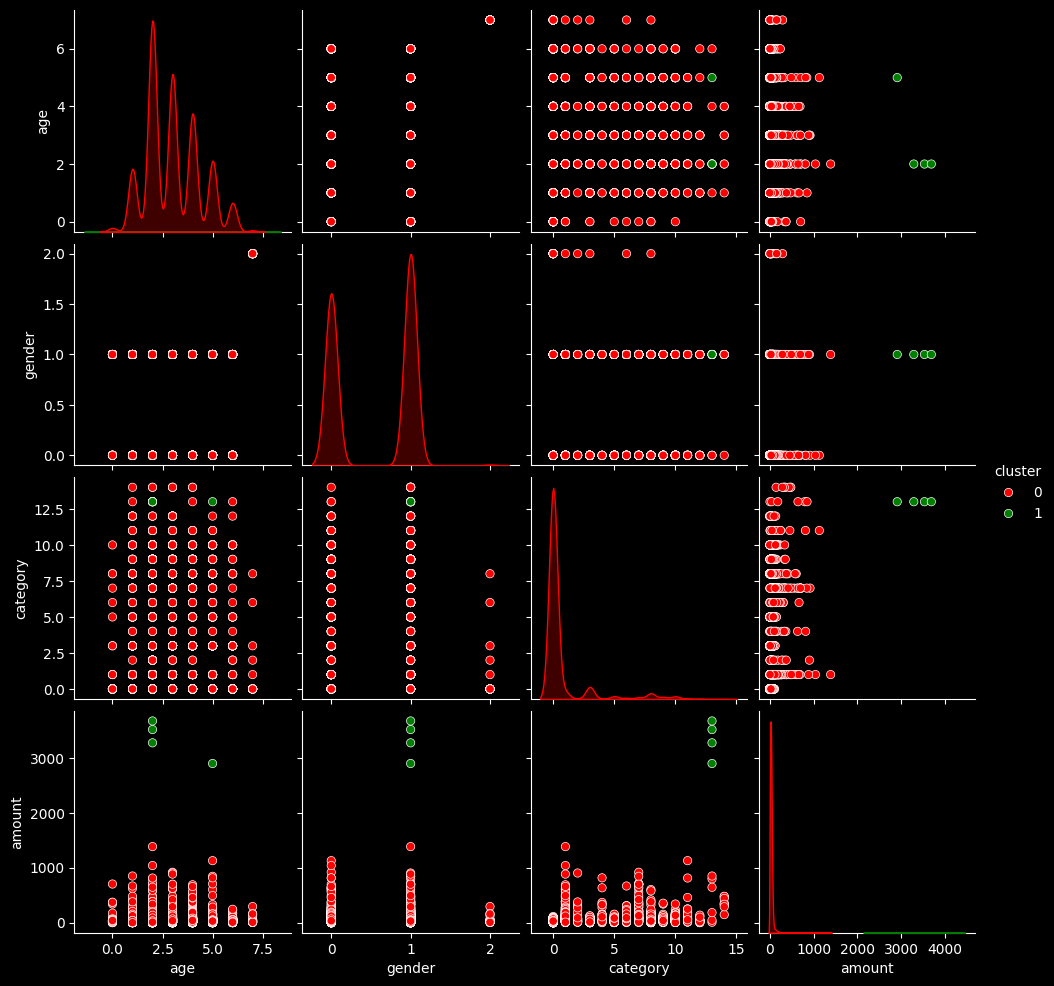

In [19]:
sns.pairplot(df.drop(columns=['fraud']).sample(10000), hue='cluster', palette=['red', 'green'])
plt.show()

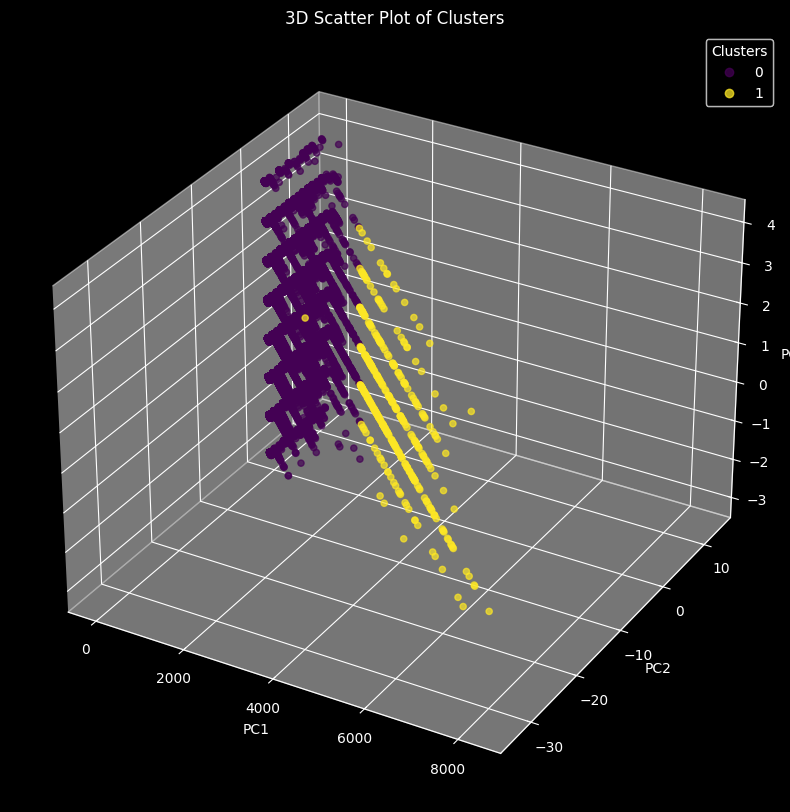

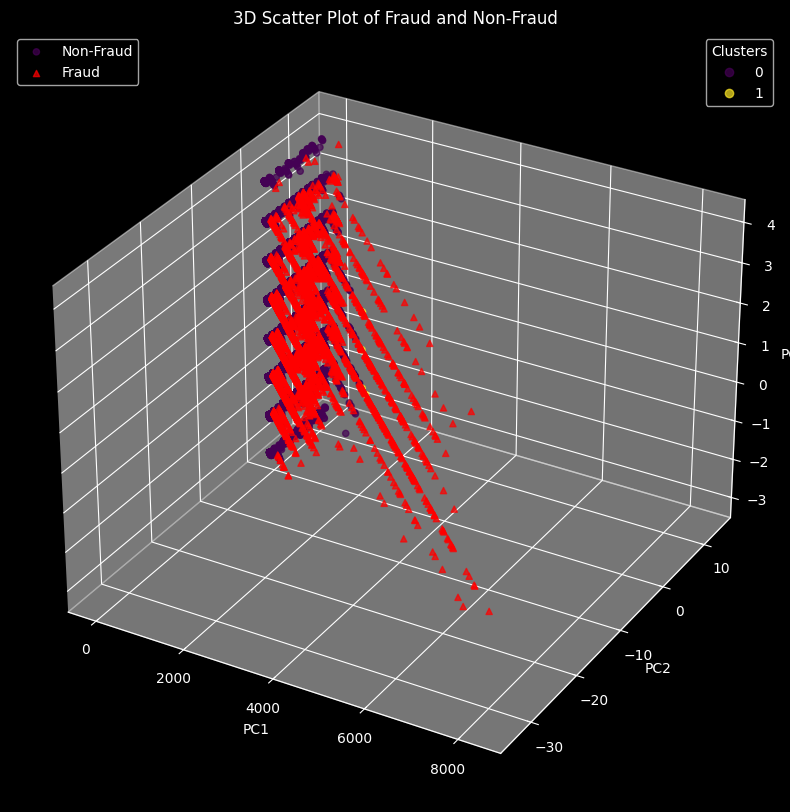

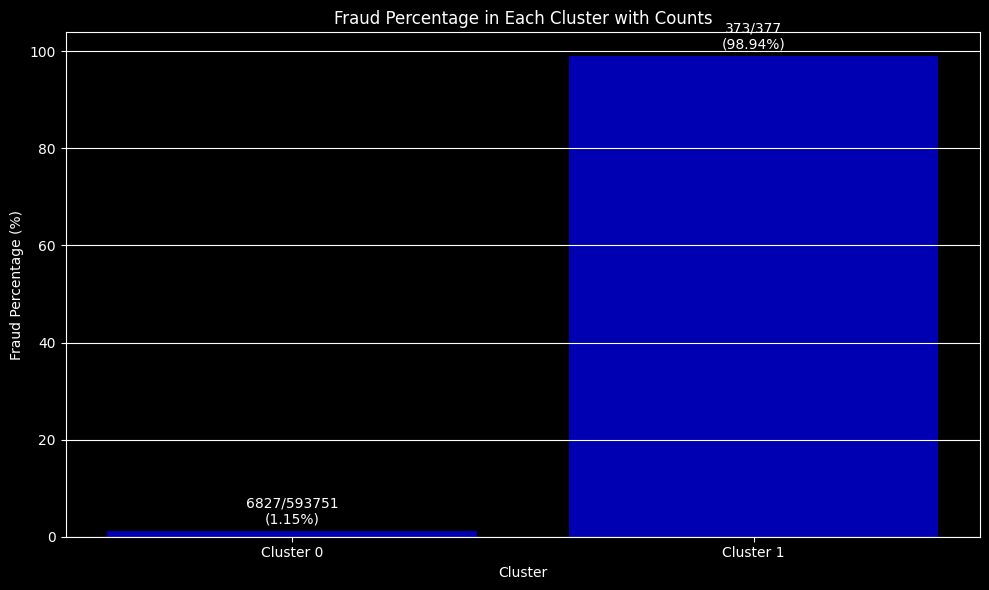

In [20]:
plot_results(df_pca)

## 3 clusters

In [21]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X)
#overwrite the cluster column in df_pca with the new cluster labels
df_pca['cluster'] = y_pred
df['cluster'] = y_pred

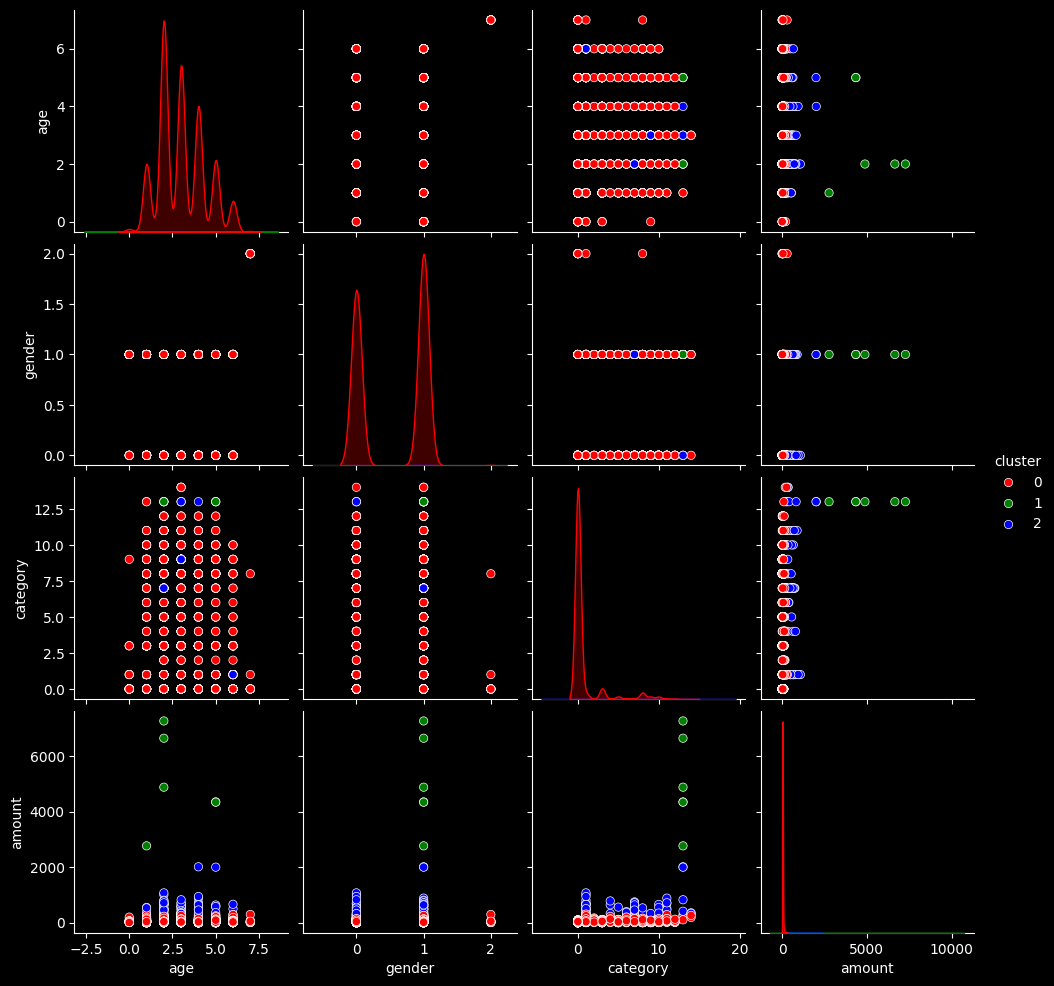

In [22]:
sns.pairplot(df.drop(columns=['fraud']).sample(10000), hue='cluster', palette=['red', 'green', 'blue'])
plt.show()

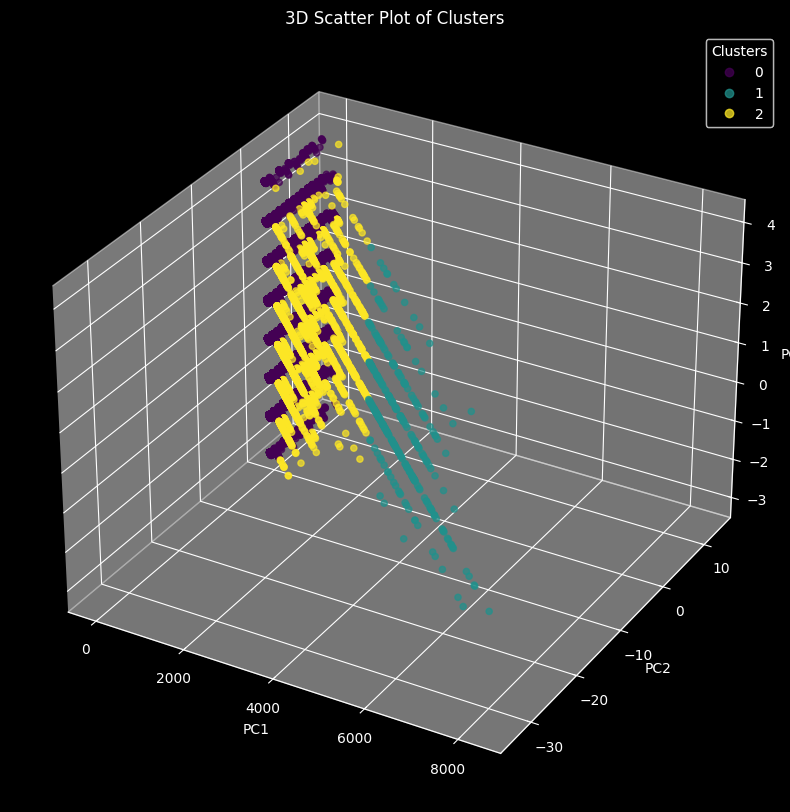

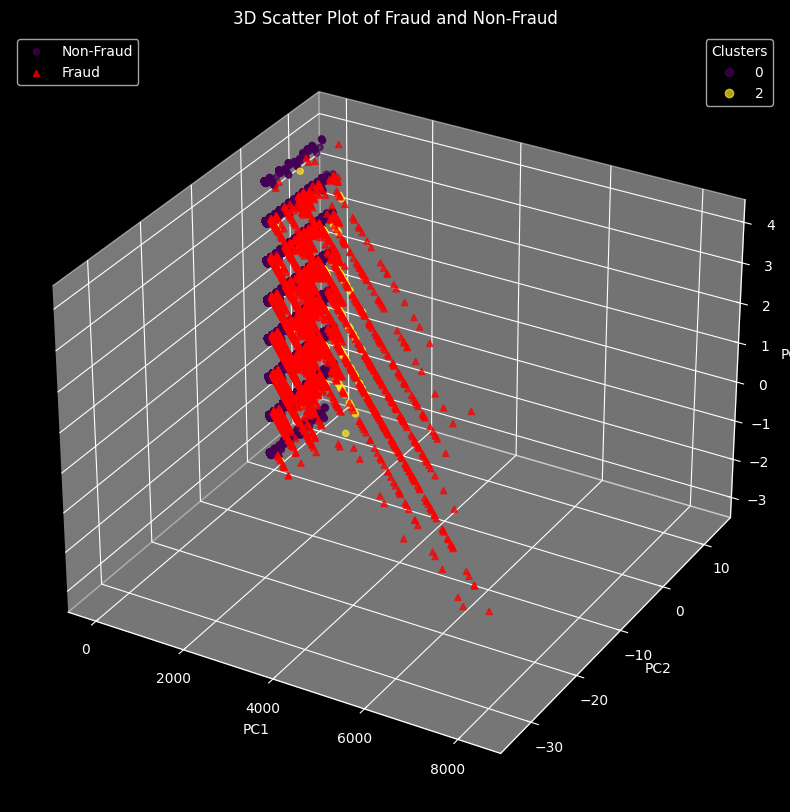

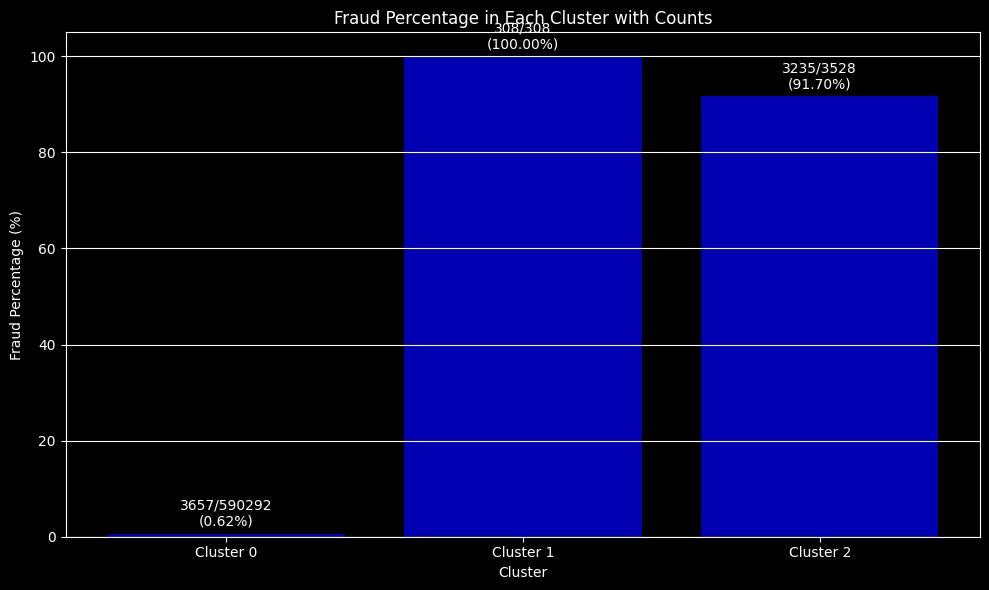

In [23]:
plot_results(df_pca)